In [1]:
import numpy as np
import matplotlib.pyplot as plt

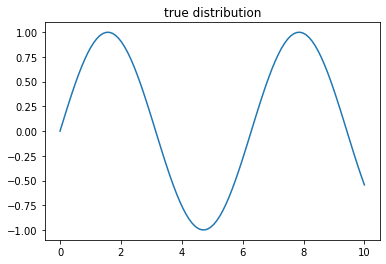

In [2]:
x_true = np.linspace(0, 10, 100)
t_true = np.sin(x_true)

plt.plot(x_true, t_true)
plt.title('true distribution')
plt.show()

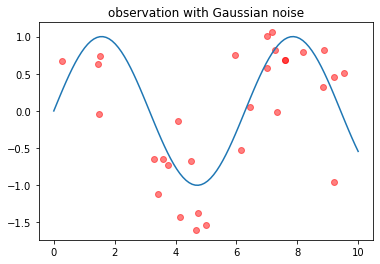

In [3]:
N = 30  # number of samples
M = 7  # number of polynomial terms

x_n = np.random.rand(N) * 10
t_n = np.sin(x_n) + 0.5 * np.random.randn(N)

plt.plot(x_true, t_true)
plt.scatter(x_n, t_n, color='red', alpha=0.5)
plt.title('observation with Gaussian noise')
plt.show()

## predictive Model

In [4]:
# y = XW
def y(x, w_m):
    out = 0
    for i, w in enumerate(w_m):
        out += w * x**i
    return out

In [5]:
# make plynomial matrix
X = []
for i in range(M+1):
    X.append(x_n**i)
X = np.array(X).T
X.shape

(30, 8)

## Solve minimization square error

In [6]:
# W = X^-1 y
w_m = np.linalg.pinv(X) @ t_n
w_m.shape

(8,)

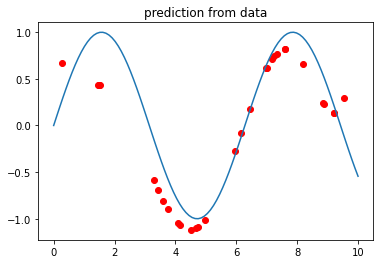

In [7]:
plt.plot(x_true, t_true)
plt.scatter(x_n, y(x_n, w_m), color='red')
plt.title('prediction from data')
plt.show()

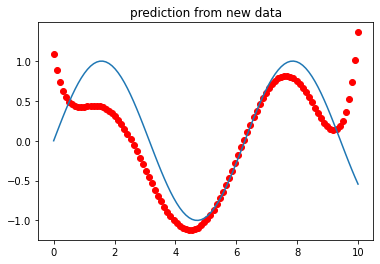

In [8]:
x_new = np.linspace(0, 10, 100)
plt.plot(x_true, t_true)
plt.scatter(x_new, y(x_new, w_m), color='red')
plt.title('prediction from new data')
plt.show()

## Maximum Likelihood 
\begin{equation}
p(t|x, \mathbf{w}) = N(t|y(x, \mathbf{w}, \beta^{-1}))
\end{equation}

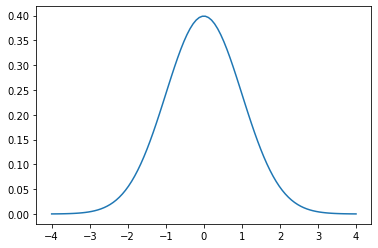

In [9]:
def Gaussian(mu, sigma):
    constant = 1/np.sqrt(2 * np.pi * sigma * sigma)
    return lambda x: constant * np.exp(- (x - mu)**2 / (2 * sigma * sigma))

N_0_1 = Gaussian(0, 1)
x = np.linspace(-4, 4, 100)
plt.plot(x, N_0_1(x))

\begin{equation}
\frac{1}{\beta_{\mathrm{ML}}} = \frac{1}{N} \sum_{n=1}^N \left\{ y(x_n, \mathbf{w_{\mathrm{ML}}}) - t_n)^2 \right\}
\end{equation}

In [10]:
beta_ML = N / np.sum((y(x_n, w_m) - t_n)**2)
print(beta_ML)

4.785011225462799


### predictive distirbution of ML
\begin{equation}
p(t|x, \mathbf{w_{\mathrm{ML}}}, \beta_{\mathrm{ML}}) = N(t|y(x, \mathbf{w_{\mathrm{ML}}}), \beta_{\mathrm{ML}}^{-1})
\end{equation}

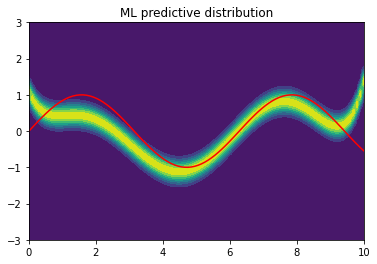

In [11]:
def pred_dist_ML(t, x, w_ML, beta_ML):
    N_y_beta = Gaussian(y(x, w_ML), 1/beta_ML)
    return N_y_beta(t)

x_new = np.linspace(0, 10, 100)
t_new = np.linspace(-3, 3, 100)
xx, tt = np.meshgrid(x_new, t_new)

z = pred_dist_ML(tt, xx, w_m, beta_ML)
plt.contourf(xx, tt, z)
plt.plot(x_true, t_true, color='red')
plt.title('ML predictive distribution')
plt.show()

## Bayes curve fitting

### predictive distribution
\begin{equation}
p(t|x, \mathbf{x, t}) = N(t|m(x), s^2(x)) \\
\end{equation}

----
\begin{equation}
\phi(x) = x^0 + x^1 + \cdots + x^M \\
\end{equation}

\begin{equation}
m(x) = \beta \phi(x)^T \mathbf{S} \sum_{n=1}^N \phi(x_n)t_n \\
\end{equation}

\begin{equation}
s^2(x) = \beta^{-1} + \phi(x)^T \mathbf{S} \phi(x) \\
\end{equation}

\begin{equation}
\mathbf{S}^{-1} = \alpha \mathbf{I} + \beta \sum_{n=1}^N \phi(x_n) \phi(x_n)^T \\
\end{equation}

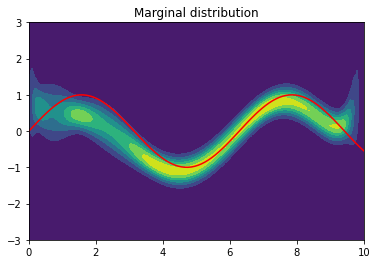

In [12]:
def phi(x):
    return np.array([x**i for i in range(M + 1)])

def pred_dist_Bayes(t, x, x_n, t_n, alpha, beta):
    S_inv = alpha * np.eye(M + 1) + beta * phi(x_n) @ phi(x_n).T
    S = np.linalg.inv(S_inv)
    m = beta * (phi(x).T @ S @ np.sum(phi(x_n) * t_n, axis=1)).T
    s2 = 1 / beta + np.sum(phi(x).T @ S * phi(x).T, axis=2)
#     s2 = 1 / beta + np.einsum('ijk, kji->ij', phi(xx).T @ S,  phi(xx))
    N_m_s2 = Gaussian(m, s2.T)
    return N_m_s2(t)

x_new = np.linspace(0, 10, 100)
t_new = np.linspace(-3, 3, 100)
xx, tt = np.meshgrid(x_new, t_new)

alpha = 5e-3
z = pred_dist_Bayes(tt, xx, x_n, t_n, alpha, beta_ML)
plt.contourf(xx, tt, z)
plt.plot(x_true, t_true, color='red')
plt.title('Marginal distribution')
plt.show()